In [81]:
import numpy as np
import pandas as pd
# %matplotlib notebook
import pickle
import os
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from collections import Counter
from sklearn import metrics
from datetime import datetime
from utils.utils import *
from joblib import Parallel, delayed

def return_important_vars(episode_presence,n_lag):
    data_file = './data/episode_encoded_lagged_data/episode_encoded_'+'lagged_{}_windows_standardized_phenotype_with_episode_cluster_check'.format(n_lag)
    if episode_presence in [0,3]:
        filename = './data/output_final/result_only_episode_lag_{}_triplet_loss.p'.format(n_lag)
    elif episode_presence in [1]:
        filename = './data/output_final/result_no_episode_lag_{}_triplet_loss.p'.format(n_lag)
    elif episode_presence in [2]:
        filename = './data/output_final/result_with_episode_lag_{}_triplet_loss_v3.p'.format(n_lag)
    # else:
        # data_directory = './data/output/episode_encoded_lag_'
        # filename = data_directory+str(n_lag)+'_episode_model_v9_new_validation_set_include_smoking_focal_loss_static_coeff_phenotype_lower_model_no_episode_v3.p'
        
    data_eval = pickle.load(open(filename,'rb'))
    file1 = './data/mRisk/mRisk_Lapse_postquit.csv'
    puff_data = pd.read_csv(file1)
    data_feature_label = pickle.load(open(data_file,'rb'))
    data_cluster = pickle.load(open(data_file,'rb'))
    temp = data_cluster.groupby(['user','cluster_label']).count().index.values
    users = np.array([a[0] for a in temp])
    labels = np.array([a[1] for a in temp])
    cluster_dict = {}
    for i,a in enumerate(users):
        cluster_dict[a] = labels[i]
    y_time = data_eval[0]
    y_pred = np.array(data_eval[1])
    y_test = data_eval[2]
    y_pid = data_eval[3]
    bias_dict = data_eval[4]
    val_results = data_eval[5]
    y_time = np.array(y_time)
    y_pred = np.array(y_pred).reshape(len(y_test),-1)
    
    y_test = np.array(y_test)
    y_pid = np.array(y_pid)
    pars = np.unique(y_pid)
    lapse_captured_dict = {}
    total_lapsers = 0
    result_phenotypes_final = {}
    for label in np.unique(list(cluster_dict.values())):
        result_phenotypes_final[label] = [0,0,0,0,[],[],[],[]]
    
    return y_pred, y_test, y_time, y_pid, lapse_captured_dict, result_phenotypes_final, cluster_dict, puff_data, data_feature_label, total_lapsers, pars, bias_dict
    

def f1Bias_scorer_CV(probs, y, ret_bias=True):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1,bias = 0.0,.5
    min_recall = .8
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and recall[i]>.7:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1


def get_results(iteration):
    all_data = []
    pred_index = indexes_pred
    final_intpday = []
    final_recall = []
    final_gap = []
    result_phenotypes = result_phenotypes_final.copy()
    for timescap in np.arange(2,240,10):
        part_days = 0
        total_ipd = 0
        lapse_captured = 0
        gap_s = []
        for key in result_phenotypes.keys():
            result_phenotypes[key][0] = 0
            result_phenotypes[key][1] = 0
            result_phenotypes[key][2] = 0
            result_phenotypes[key][3] = 0
            result_phenotypes[key][4] = []
        total_lapsers = 0
        for i,par in enumerate(pars):
            a = np.where(y_pid==par)[0]
            # lapse_times = np.array([np.datetime64(lapse_time, 'ms')  for lapse_time in puff_data[puff_data['Participant']==int(par)]['Lapse'].values])
            lapse_times = np.array([np.datetime64(datetime.fromtimestamp(lapse_time/1000)) for lapse_time in puff_data[puff_data['Participant']==int(par)]['Lapse'].values])
            total_lapsers+=len(lapse_times)
            result_phenotypes[cluster_dict[par]][3]+=len(lapse_times)
            # - np.timedelta64(5, 'h')
            
            y_pred_pid = y_pred[a][:,pred_index]
            from sklearn.preprocessing import MinMaxScaler
            # y_pred_pid = MinMaxScaler().fit_transform(y_pred_pid)
            biases = np.array(bias_dict[par])[pred_index]
            for ii in range(y_pred_pid.shape[1]):
                y_pred_pid[:,ii] = np.array(y_pred_pid[:,ii]>=biases[ii],dtype=int)
            y_pred_pid = np.mean(y_pred_pid,axis=1)
            
            y_test_pid = y_test[a]
            y_time_pid = y_time[a]
            y_time_pid = np.array([y+np.timedelta64(time_gap_delta, 'm') for y in y_time_pid])
            y_pred_pid = y_pred_pid[y_time_pid.argsort()]
            y_test_pid = y_test_pid[y_time_pid.argsort()]
            y_time_pid = np.array(sorted(y_time_pid))
            y_day_pid = np.array([str(a)[:10] for a in y_time_pid])
            # df = pd.DataFrame({'time':y_time_pid,'prob':y_pred_pid})
            # y_pred_pid = df['prob'].rolling(window=10).mean().fillna(0).values
            # bias = np.percentile(y_pred_pid,70)
            # f1,bias=f1Bias_scorer_CV(y_pred_pid,y_test_pid)
            # print(f1,'f1',par,'bias',bias)
            # b = (np.where(y_test_pid>0))
            bias = 0.68
            udays = len(np.unique(y_day_pid))
            part_days+=udays
            result_phenotypes[cluster_dict[par]][0]+=udays
            
            ipd = 0
            int_times = []
            prev_time = np.min(y_time_pid)
            # plt.hist(y_pred_pid)
            # plt.show()
            for p,ys in enumerate(y_pred_pid):
                timedelta = y_time_pid[p] - prev_time
                mins = timedelta.astype('timedelta64[m]').astype(np.int32)
                if mins>=timescap and ys>bias:
                    ipd+=1
                    int_times.append(y_time_pid[p])
                    prev_time = y_time_pid[p]
                    
            total_ipd+=ipd
            result_phenotypes[cluster_dict[par]][1]+=ipd
            int_times = np.array(int_times)
            if len(int_times)>0:
                for lapse_time in lapse_times:
                    int_times_lapse = sorted(np.array([a for a in int_times if a<lapse_time]))
                    if len(int_times_lapse)==0:
                        continue
                    # print(lapse_time- int_times_lapse.max(),'gap')
                    gap_lapse_ = lapse_time- np.max(int_times_lapse)
                    gap_lapse_ = gap_lapse_.astype('timedelta64[m]').astype(np.int32)
                    
                    if abs(gap_lapse_)<gap_th:
                        lapse_captured+=1
                        result_phenotypes[cluster_dict[par]][2]+=1
                    if gap_lapse_<500:
                        gap_s.append(abs(gap_lapse_))
                        result_phenotypes[cluster_dict[par]][4].append(abs(gap_lapse_)) 
            
        final_day_th = float(total_ipd)/part_days
        final_intpday.append(final_day_th)
        final_gap.append(np.median(gap_s))
        final_recall.append(float(lapse_captured)/total_lapsers)
        # print(total_lapsers,part_days,total_ipd/part_days,final_recall[-1])
        for key in result_phenotypes.keys():
            average_int = float(result_phenotypes[key][1])/result_phenotypes[key][0]
            captured_lapse = float(result_phenotypes[key][2])/result_phenotypes[key][3]
            mean_gap = np.mean(result_phenotypes[key][4])
            result_phenotypes[key][5].append(average_int)
            result_phenotypes[key][6].append(captured_lapse)
            result_phenotypes[key][7].append(mean_gap)
    # print(list(zip(final_intpday,final_recall)))
    result_final = get_smoothed_result(final_intpday,final_recall,final_gap)
    # result_final[np.where(result_final[:,0]<=6)[0],1] += .1
    result_final = get_interpolated_data(result_final,x,name='Overall',iteration=iteration)
    all_data.extend(result_final)
    for key in result_phenotypes.keys():
        result_this_cluster = get_smoothed_result(result_phenotypes[key][5],
                                                        result_phenotypes[key][6],
                                                        result_phenotypes[key][7])
        result_final_cluster = get_interpolated_data(result_this_cluster,x,name='Cluster {}'.format(key),iteration=iteration)
        all_data.extend(result_final_cluster)
    return all_data

def get_df(df):
    # print(df.shape,'df shape')
    if df.shape[0]==0:
        return df
    df = df.sort_values('time').reset_index(drop=True)
    timescap = df['timescap'].values[0]//2
    indexes = np.arange(timescap)
    # index = df.index.values
    index = np.random.choice(indexes,1)[0]
    # print(index,'index sampled')
    if index>df.shape[0]-1:
        return df
    # print(index)
    df['pred'].at[index] = 1
    return df



import math
def get_baseline_result(iteration):
    all_data = []
    final_intpday = []
    final_recall = []
    final_gap = []
    from copy import deepcopy
    result_phenotypes = deepcopy(result_phenotypes_final)
    for timescap in list(np.arange(10,240,10)):
        part_days = 0
        total_ipd = 0
        lapse_captured = 0
        gap_s = []
        total_lapsers = 0
        for key in result_phenotypes.keys():
            result_phenotypes[key][0] = 0
            result_phenotypes[key][1] = 0
            result_phenotypes[key][2] = 0
            result_phenotypes[key][3] = 0
            result_phenotypes[key][4] = []
        
        for i,par in enumerate(pars):
            a = np.where(y_pid==par)
            lapse_times = np.array([np.datetime64(datetime.fromtimestamp(lapse_time/1000)) for lapse_time in puff_data[puff_data['Participant']==int(par)]['Lapse'].values])
            total_lapsers+=len(lapse_times)
            result_phenotypes[cluster_dict[par]][3]+=len(lapse_times)
            
            y_time_pid = y_time[a]
            y_time_pid = np.array([y+np.timedelta64(time_gap_delta, 'm') for y in y_time_pid])
            y_time_pid = np.array(sorted(y_time_pid))
            y_day_pid = np.array([str(a)[:10] for a in y_time_pid])
            total_minutes = 0
            for day in np.unique(y_day_pid):
                y_time_pid1 = sorted(y_time_pid[y_day_pid==day])
                total_minutes+= (y_time_pid1[-1]-y_time_pid1[0]).astype('timedelta64[m]').astype(np.int32)
            ipd = math.ceil(total_minutes/timescap)
            udays = len(np.unique(y_day_pid))
            part_days+=udays
            result_phenotypes[cluster_dict[par]][0]+=udays
            
            df_pid = pd.DataFrame({'time':y_time_pid,
                                    'pred':[0]*len(y_time_pid)})
            df_pid['timescap'] = timescap
            df_all = df_pid.groupby(pd.Grouper(key='time',freq=str(60*timescap)+'S')).apply(get_df)
            int_times = df_all[df_all.pred==1]['time'].values
            # total_ipd+=ipd
            # result_phenotypes[cluster_dict[par]][1]+=ipd
            if len(int_times)>0:
                for lapse_time in lapse_times:
                    int_times_lapse = sorted(np.array([a for a in int_times if a<lapse_time]))
                    if len(int_times_lapse)==0:
                        continue
                    gap_lapse_ = lapse_time- np.max(int_times_lapse)
                    gap_lapse_ = gap_lapse_.astype('timedelta64[m]').astype(np.int32)
                    if abs(gap_lapse_)<gap_th:
                        lapse_captured+=1     
                        result_phenotypes[cluster_dict[par]][2]+=1       
                    if gap_lapse_<200:
                        gap_s.append(abs(gap_lapse_))
                        result_phenotypes[cluster_dict[par]][4].append(abs(gap_lapse_)) 
            
            total_ipd+=ipd
            result_phenotypes[cluster_dict[par]][1]+=ipd
            
        final_day_th = float(total_ipd)/part_days
        final_intpday.append(final_day_th)
        final_gap.append(np.mean(gap_s))
        # print(total_lapsers)
        final_recall.append(float(lapse_captured)/total_lapsers)
        # print(total_lapsers,part_days,total_ipd/part_days,final_recall[-1])
        
        for key in result_phenotypes.keys():
            # print(result_phenotypes[key][:4])
            
            average_int = float(result_phenotypes[key][1])/result_phenotypes[key][0]
            captured_lapse = float(result_phenotypes[key][2])/result_phenotypes[key][3]
            # print(captured_lapse>1)
            mean_gap = np.median(result_phenotypes[key][4])
            result_phenotypes[key][5].append(average_int)
            result_phenotypes[key][6].append(captured_lapse)
            result_phenotypes[key][7].append(mean_gap)
            
    result_final = get_smoothed_result(final_intpday,final_recall,final_gap)
    result_final = get_interpolated_data(result_final,x,name='Overall',iteration=iteration)
    all_data.extend(result_final)
    for key in result_phenotypes.keys():
        result_this_cluster = get_smoothed_result(result_phenotypes[key][5],
                                                        result_phenotypes[key][6],
                                                        result_phenotypes[key][7])
        result_final_cluster = get_interpolated_data(result_this_cluster,x,name='Cluster {}'.format(key),iteration=iteration)
        all_data.extend(result_final_cluster)
    return all_data
                
                
time_gap_delta = 0
gap_th = 60
inc = ['3002', '3004', '3005', '3006', '3007', '3009', '3013', '3014', '3015', '3022', '3024', '3025', '3029', '3031', '3033',
 '3036', '3038', '3041', '3045', '3048', '3050', '3053', '3076', '3077', '3079', '3086', '3088', '3091', '3095', '3099',
 '3101', '3102', '3122', '3125', '3126', '3128', '3133', '3135', '3137', '3138', '3139', '3143', '3145', '3148', '3152',
 '3153', '3158', '3160', '3164', '3165', '3166', '3168']
n_lag = 15
n_iters = 1
n_sample = 5
x = np.array(list(np.arange(2,10.5,.5)))
df_all = []
for episode_presence in [0,1,2,3]:
    y_pred, y_test, y_time, y_pid, lapse_captured_dict, result_phenotypes_final, cluster_dict, puff_data, data_feature_label, total_lapsers, pars, bias_dict = return_important_vars(episode_presence=episode_presence,n_lag=n_lag)
    indexes_pred = np.arange(y_pred.shape[1])
    if episode_presence in [0,1,2]:
        all_data_v1 = Parallel(n_jobs=-1,verbose=2)(delayed(get_results)(iteration) for iteration in np.arange(n_iters))
        # all_data_v1 = [get_results(iteration) for iteration in np.arange(n_iters)]
    elif episode_presence in [3]:
        n_iters = 20
        all_data_v1 = Parallel(n_jobs=-1,verbose=2)(delayed(get_baseline_result)(iteration) for iteration in np.arange(n_iters))
        # all_data_v1 = [get_baseline_result(iteration) for iteration in np.arange(n_iters)]
    all_data = []
    for a in all_data_v1:
        all_data.extend(a)
    df2 = pd.DataFrame(all_data,columns=['Interventions per day','IHR','TPI','Subtype','Iteration'])
    if episode_presence==0:
        df2['Encoding'] = ['Using Proposed Encoding (Both continuous and event features)']*df2.shape[0]
    elif episode_presence==1:
        df2['Encoding'] = ['Deep Model with Lagged Observation Windows']*df2.shape[0]
    elif episode_presence==2:
        df2['Encoding'] = ['Using Only Proposed Encoding of Event Streams']*df2.shape[0]
    elif episode_presence==3:
        df2['Encoding'] = ['Baseline Result with Random Intervention']*df2.shape[0]
    df_all.append(df2)

df=pd.concat(df_all)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/home/azim/miniconda3/envs/test1/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:   42.0s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   46.8s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | ela

No handles with labels found to put in legend.


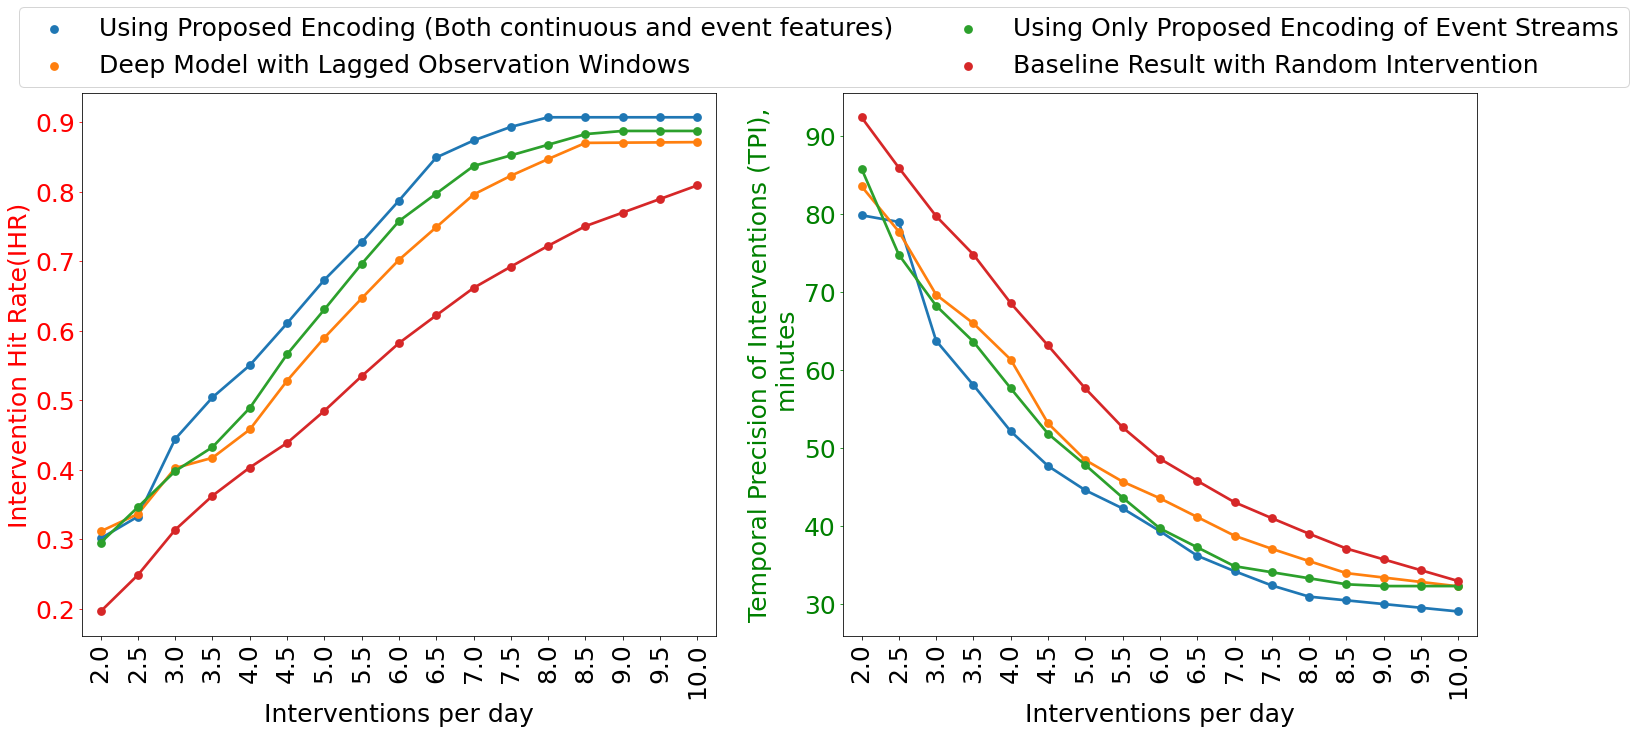

In [82]:
import seaborn as sns
df_final = df
plt.rcParams.update({'font.size':25})
fig,ax = plt.subplots(1,2,figsize=(25,10),sharex=False)
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df_final[df_final.Subtype.isin(['Overall'])],ci=None,ax=ax[0])
plt.legend(loc='lower right')
# ax[0].grid()
ax[0].set_ylabel('Intervention Hit Rate(IHR)',color='r')
ax[0].legend([],[], frameon=False)
ax[0].tick_params(axis='y', colors='red')
ax[0].tick_params(axis='x', rotation=90)

# ax1=ax.twinx()
sns.pointplot(x='Interventions per day',y='TPI',hue='Encoding',data=df_final[df_final.Subtype.isin(['Overall'])],ci=None,ax=ax[1])
ax[1].set_ylabel('Temporal Precision of Interventions (TPI),\n minutes',color='g')
ax[1].tick_params(axis='y', colors='g')
plt.xticks(rotation=90)
# ax[1].grid()
ax[1].legend(loc=(-1.3,1.01),ncol=2)
# plt.tight_layout()
# plt.savefig('./data/images/deep_model.png')
# plt.tight_layout()
plt.show()

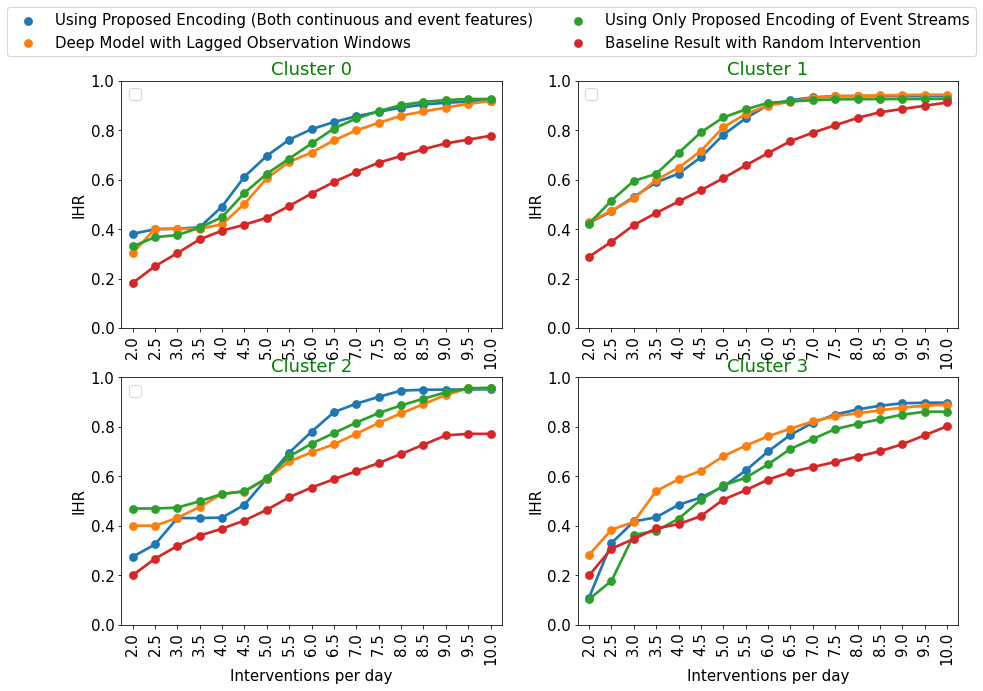

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# df  = pickle.load(open('./data/saved_result/ihr_tpi_dataframe.p','rb'))
df  = df_final
plt.rcParams.update({'font.size':15})
fig,ax = plt.subplots(2,2,figsize=(15,10))
ax = np.array(ax).reshape((2,2))
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 0'])],ci=None,ax=ax[0,0])
ax[0,0].set_ylim([0,1])
ax[0,0].set_xlabel('')
ax[0,0].set_title('Cluster 0',color='g')
ax[0,0].legend([],[])
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 1'])],ci=None,ax=ax[0,1])
ax[0,1].set_ylim([0,1])
ax[0,1].set_xlabel('')
ax[0,1].set_title('Cluster 1',color='g')
ax[0,1].legend([],[])
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 2'])],ci=None,ax=ax[1,0])
ax[1,0].set_ylim([0,1])
ax[1,0].set_title('Cluster 2',color='g')
ax[1,0].legend([],[])
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 3'])],ci=None,ax=ax[1,1])
ax[1,1].set_ylim([0,1])
ax[1,1].set_title('Cluster 3',color='g')
ax[1,1].legend(loc=(-1.5,2.3),ncol=2)
ax[0,0].tick_params(axis='x', rotation=90)
ax[0,1].tick_params(axis='x', rotation=90)
ax[1,0].tick_params(axis='x', rotation=90)
ax[1,1].tick_params(axis='x', rotation=90)

# plt.show()
# plt.figure(figsize=(20,10))
# sns.pointplot(x='Interventions per day',y='TPI',hue='Subtype',data=df[df.Encoding.isin(['Proposed Episode Encoding']) & ~df.Subtype.isin(['Overall'])],ci='sd',ax=ax[1])
# plt.tight_layout()
# plt.savefig('./data/images/cluster_performance.png')
plt.show()

In [ ]:
data_file = './data/episode_encoded_lagged_data/episode_encoded_'+'lagged_{}_windows_standardized_phenotype_with_episode_cluster_check'.format(n_lag)

In [ ]:
data = pickle.load(open(data_file,'rb'))

In [ ]:
data.head()